<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - UEBA: Detección de Anomalías</p>
<p style="margin: 0; text-align:right;">20231 - Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Alejandro Ortega de los Ríos
</div>

# Extracción de características - Device

In [3]:
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#Exporto ficheros
device_df = pd.read_csv('../data/device.csv')
features = pd.read_csv('features.csv')

In [7]:
device_df.head()

,id,date,user,pc,activity
0,{J1S3-L9UU75BQ-7790ATPL},01/02/2010 07:21:06,MOH0273,PC-6699,Connect
1,{N7B5-Y7BB27SI-2946PUJK},01/02/2010 07:37:41,MOH0273,PC-6699,Disconnect
2,{U1V9-Z7XT67KV-5649MYHI},01/02/2010 07:59:11,HPH0075,PC-2417,Connect
3,{H0Z7-E6GB57XZ-1603MOXD},01/02/2010 07:59:49,IIW0249,PC-0843,Connect
4,{L7P2-G4PX02RX-7999GYOY},01/02/2010 08:04:26,IIW0249,PC-0843,Disconnect


In [8]:
#Lista de usuarios maliciosos
insiders_list = features[features['insider'] == 1]['user'].tolist()

In [10]:
users = device_df['user'].unique()
len(users)

265

In [11]:
device_insiders_list = [insider for insider in users if insider in insiders_list]
print(len(device_insiders_list))

70


## 1. Número de conexiones al día

In [40]:
#Organizo el dataset en registros actividad por usuario (connect-disconnect)
device_df.sort_values(by=['user', 'date', 'activity'], inplace=True)

In [44]:
device_df.head()

,id,date,user,pc,activity
1950,{X9U6-C5DZ44YB-2679MEAA},01/05/2010 11:45:35,AAF0535,PC-2408,Connect
1972,{P3W1-F1BG76GJ-9248ZOCU},01/05/2010 12:05:16,AAF0535,PC-2408,Disconnect
2294,{I9X6-W6PW93FK-8510IFLP},01/05/2010 15:00:02,AAF0535,PC-2408,Connect
2302,{N3G6-W7HT07SZ-2437PYMD},01/05/2010 15:03:36,AAF0535,PC-2408,Disconnect
3521,{I9D7-P5KX84DF-0543NXRR},01/06/2010 14:53:30,AAF0535,PC-2408,Connect


In [65]:
#Ficheros diarios. Obtengo fecha, hora y día de la semana
device_df['date'] = pd.to_datetime(device_df['date'], format='%m/%d/%Y %H:%M:%S')
device_df['time'] = device_df['date'].dt.strftime('%H:%M:%S')
device_df['date'] = device_df['date'].dt.floor('d')
device_df['weekday'] = device_df['date'].dt.dayofweek

# Filtro registros para días laborables y fines de semana
weekday_connections = device_df[device_df['weekday'] < 5]
weekend_connections = device_df[device_df['weekday'] >= 5]

# Calculo el número de conexiones por día para cada usuario, dividido por 2 para tener solo las conexiones
weekday_connections_per_day = weekday_connections.groupby(['user', 'date']).size() / 2
weekend_connections_per_day = weekend_connections.groupby(['user', 'date']).size() / 2

# Calculo la conexión media diaria por usuario para días laborables y fines de semana
weekday_daily_connections = weekday_connections_per_day.groupby('user').mean()
weekend_daily_connections = weekend_connections_per_day.groupby('user').mean()

C:\Users\alexo\AppData\Local\Temp\ipykernel_22748\2524110015.py:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  axes[1].hist(weekend_daily_connections[weekend_insiders], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')


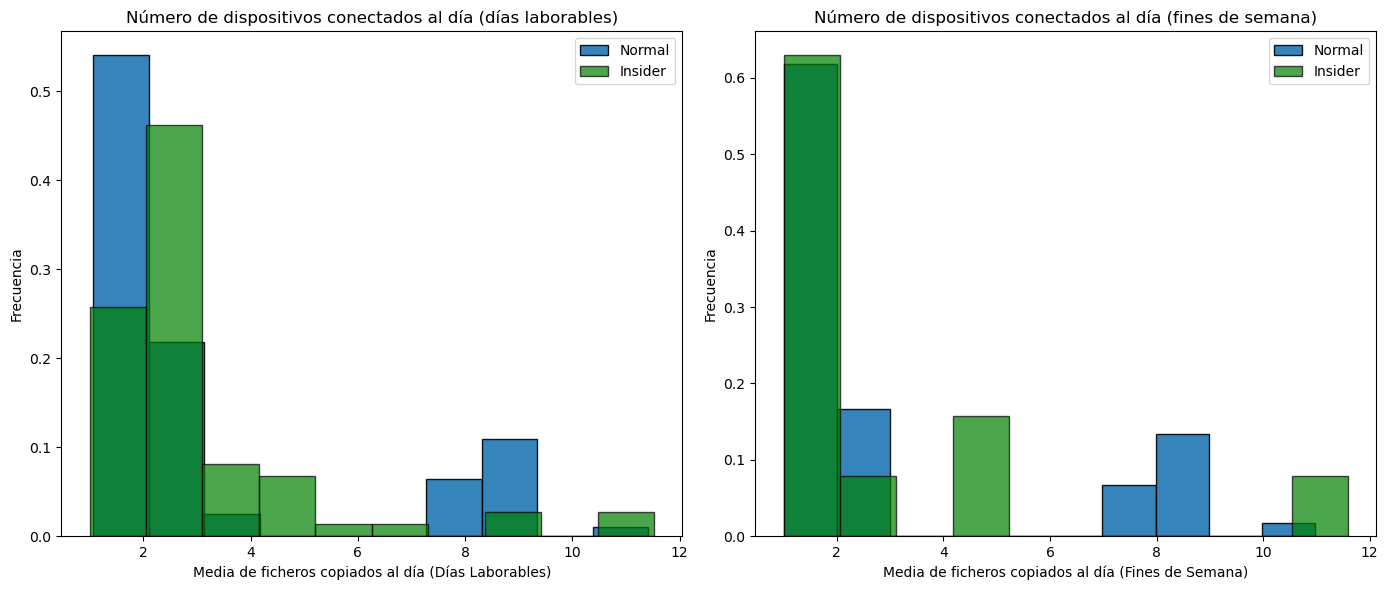

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histograma para días laborables
axes[0].hist(weekday_daily_connections[~weekday_daily_connections.index.isin(insiders_list)], edgecolor='black', alpha=0.9, density=True, label='Normal')
axes[0].hist(weekday_daily_connections[insiders_list], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')
axes[0].set_xlabel('Media de dispositivos al día (Días Laborables)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Número de dispositivos conectados al día (días laborables)')
axes[0].legend()

# Histograma para fines de semana
weekend_insiders = set(weekend_daily_connections.index.tolist()) & set(insiders_list)

axes[1].hist(weekend_daily_connections[~weekend_daily_connections.index.isin(weekend_insiders)], edgecolor='black', alpha=0.9, density=True, label='Normal')
axes[1].hist(weekend_daily_connections[weekend_insiders], edgecolor='black', color='green', alpha=0.7, density=True, label='Insider')
axes[1].set_xlabel('Media de dispositivos conectados al día (Fines de Semana)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Número de dispositivos conectados al día (fines de semana)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [84]:
#Creo un diccionario a partir de weekend_emails
weekend_device_dict = weekend_daily_connections.to_dict()
weekday_device_dict = weekday_daily_connections.to_dict()

# Mapeo el diccionario, le asigno valor si existe, y si no existe le asigno cero
features['weekend_device'] = features['user'].map(weekend_device_dict).fillna(0).astype(int)
features['weekday_device'] = features['user'].map(weekday_device_dict).fillna(0).astype(int)

In [89]:
#Visualizo características
features.drop(columns=['Unnamed: 0'], inplace=True)
features.head()

,user,email_size,attachments,recipients,working_day_emails,address_count,weekend_emails,insider,working_day_files,weekend_files,doc,exe,jpg,pdf,txt,zip,weekend_device,weekday_device
0,LAP0338,30020.394184,0.377839,1.638930,13.655072,2,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0
1,MOH0273,30397.402083,0.758333,1.670833,2.962963,2,8,0,23,22,14.877805,0.117207,1.167082,4.683292,1.189526,1.17207,8,7
2,HVB0037,29958.497676,0.000000,1.658367,8.705202,3,13,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0
3,NWK0215,29828.181548,0.431548,1.651786,1.000000,2,12,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,0
4,LRR0148,29895.532625,0.930197,1.587253,2.941964,2,13,0,3,3,2.273438,0.011719,0.218750,0.671875,0.179688,0.18750,2,2


In [91]:
#Exporto resultados
features.to_csv('features.csv')